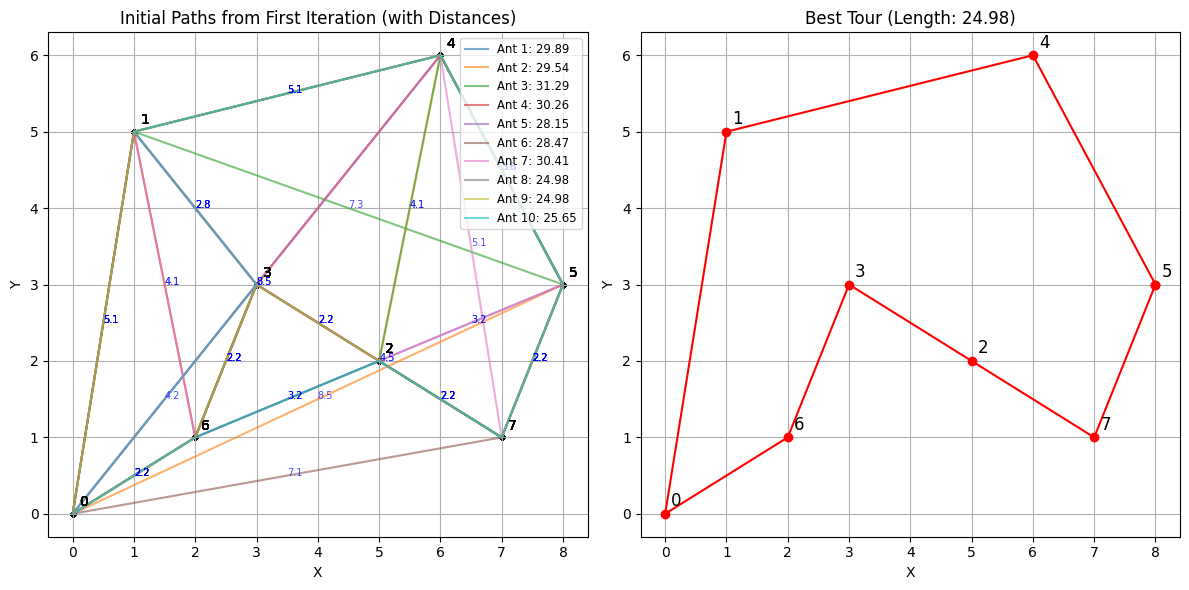

In [1]:
# Recreate and save the commented ACO TSP code after environment reset

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import random

# Define the coordinates of cities (each is a point on a 2D plane)
cities = np.array([
    [0, 0], [1, 5], [5, 2], [3, 3], [6, 6], [8, 3], [2, 1], [7, 1]
])

# Set ACO parameters
num_ants = 10              # Number of ants
num_iterations = 100       # How many generations to run
alpha = 1.0                # Influence of pheromone
beta = 5.0                 # Influence of distance
evaporation = 0.5          # Rate of pheromone evaporation
Q = 100                    # Pheromone deposit factor

# Calculate the Euclidean distance between every pair of cities
num_cities = len(cities)
distance = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        if i != j:
            distance[i][j] = np.linalg.norm(cities[i] - cities[j])

# Initialize the pheromone matrix (equal pheromone on all paths initially)
pheromone = np.ones((num_cities, num_cities))

# Function to calculate the total distance of a given tour
def tour_length(tour):
    return sum(distance[tour[i % num_cities]][tour[(i + 1) % num_cities]] for i in range(num_cities))

# Variables to track the best tour found
best_tour = None
best_length = float('inf')
first_iteration_paths = []

# Begin the main ACO loop
for iteration in range(num_iterations):
    all_tours = []
    all_lengths = []

    for ant in range(num_ants):
        # Randomly choose the starting city
        tour = [random.randint(0, num_cities - 1)]
        visited = set(tour)

        # Construct the complete tour
        while len(tour) < num_cities:
            current = tour[-1]
            probabilities = []

            # Calculate probability for each unvisited city
            for next_city in range(num_cities):
                if next_city not in visited:
                    tau = pheromone[current][next_city] ** alpha
                    eta = (1 / distance[current][next_city]) ** beta
                    probabilities.append((next_city, tau * eta))

            # Normalize the probabilities
            total = sum(p[1] for p in probabilities)
            probs = [(p[0], p[1] / total) for p in probabilities]

            # Roulette wheel selection to pick next city
            r = random.random()
            cumulative = 0.0
            for city, prob in probs:
                cumulative += prob
                if r <= cumulative:
                    tour.append(city)
                    visited.add(city)
                    break

        # Store the tour and its length
        all_tours.append(tour)
        length = tour_length(tour)
        all_lengths.append(length)

        # Save paths from first iteration for plotting
        if iteration == 0:
            first_iteration_paths.append((tour[:], length))

        # Update best tour if this one is shorter
        if length < best_length:
            best_length = length
            best_tour = tour[:]

    # Update pheromones
    pheromone *= (1 - evaporation)
    for tour, length in zip(all_tours, all_lengths):
        for i in range(num_cities):
            a = tour[i % num_cities]
            b = tour[(i + 1) % num_cities]
            pheromone[a][b] += Q / length
            pheromone[b][a] += Q / length  # for symmetry

# Plotting results
best_tour.append(best_tour[0])
tour_coords = cities[best_tour]

plt.figure(figsize=(12, 6))

# Subplot 1: All initial ant paths
plt.subplot(1, 2, 1)
for i, (path, length) in enumerate(first_iteration_paths):
    path_plot = path + [path[0]]
    coords = cities[path_plot]
    plt.plot(coords[:, 0], coords[:, 1], label=f"Ant {i+1}: {length:.2f}", alpha=0.6)
    for x, y in coords:
        plt.scatter(x, y, color='black', s=10)
    for idx, (x, y) in enumerate(cities):
        plt.text(x + 0.1, y + 0.1, str(idx), fontsize=10)
    # Add distances between cities
    for j in range(len(path_plot) - 1):
        x1, y1 = cities[path_plot[j]]
        x2, y2 = cities[path_plot[j + 1]]
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
        d = np.linalg.norm([x1 - x2, y1 - y2])
        plt.text(mid_x, mid_y, f"{d:.1f}", fontsize=7, color='blue', alpha=0.7)

plt.title("Initial Paths from First Iteration (with Distances)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(fontsize='small', loc='upper right')
plt.grid(True)

# Subplot 2: Final best path
plt.subplot(1, 2, 2)
plt.plot(tour_coords[:, 0], tour_coords[:, 1], 'ro-')
for i, (x, y) in enumerate(cities):
    plt.text(x + 0.1, y + 0.1, str(i), fontsize=12)
plt.title(f"Best Tour (Length: {best_length:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

plt.tight_layout()
plt.savefig("aco_tsp_result.png")
plt.show()


